In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv
import pandas as pd
import scipy.optimize as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%run ../aux_funcs.py
%run ../RSRG.py
%run ../RSRG_class.py

In [26]:
log_file = pd.read_csv("log_file.csv")
ts_list = log_file['ts'].tolist()
log_file

,L,steps,a,b,w,n_runs,ts
0,40,1584,0.1,0.105,1.0,60,1677874750
1,40,1584,0.1,0.105,1.5,60,1677875074
2,40,1584,0.1,0.105,2.0,60,1677875398
3,40,1584,0.1,0.105,2.5,60,1677875741
4,40,1584,0.1,0.105,3.0,60,1677876102
...,...,...,...,...,...,...,...
119,30,892,0.1,0.105,2.5,60,1678144807
120,30,892,0.1,0.105,2.7,60,1678144998
121,30,892,0.1,0.105,2.9,60,1678145193
122,30,892,0.1,0.105,3.1,60,1678145391


In [27]:
ts = str(ts_list[-3])

with open("Ising_2D_output_"+ts+".pkl", "rb") as fp:   # Unpickling
    output_data = pickle.load(fp)

with open("Ising_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
    
Omegas = np.array([])
dec_types = np.array([])
h_array, J_array = [], []


for core, item in enumerate(output_data):
    J_dist_list, h_dist_list, Omega_list_composite, decimation_type_composite = item
    Omegas = np.concatenate((Omegas, Omega_list_composite))
    dec_types = np.concatenate((dec_types, decimation_type_composite))
    if core==0:
        h_array = h_dist_list
        J_array = J_dist_list

    else:
        for i in range(len(input_dict['measure_list'])):
            h_array[i] = np.concatenate((h_array[i], h_dist_list[i]))
            J_array[i] = np.concatenate((J_array[i], J_dist_list[i]))
        
        
with open("Ising_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
#print(input_dict)


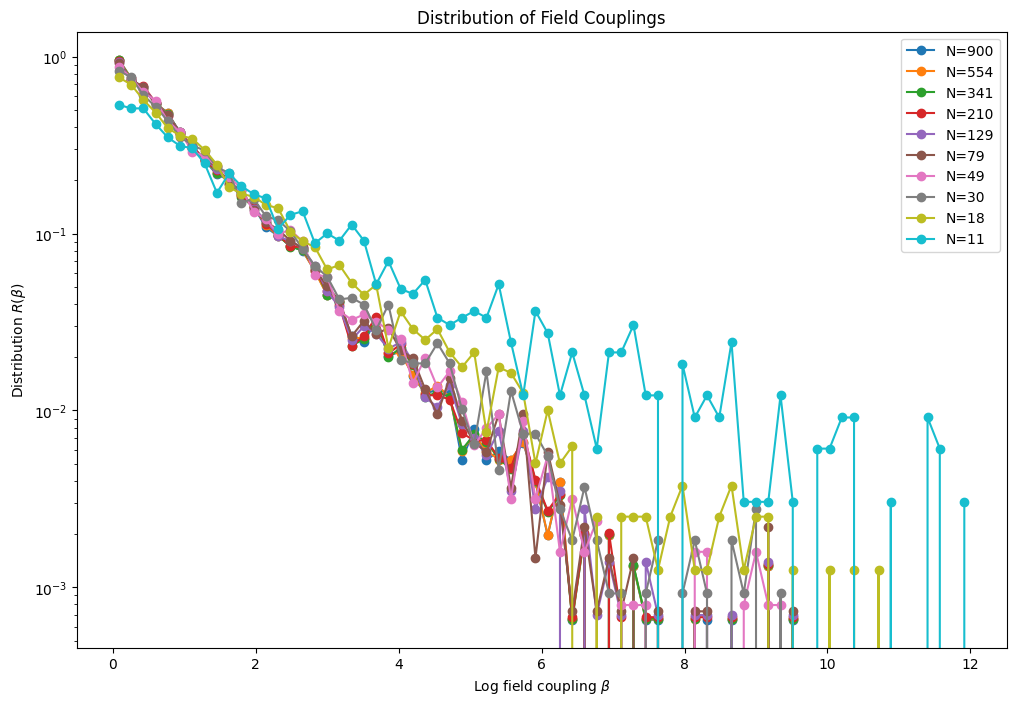

In [28]:
measure_list = input_dict['measure_list']
n_runs = input_dict['n_runs']
n_bins_h = 70
width_list = []
plt.figure(figsize=(12, 8))

for i,step in enumerate(measure_list[:-1]): 
    n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
    width = bins[1]-bins[0]
    x = (bins[1:]-width/2)
    y = n
    if i%2==0: plt.plot(x, y, label="N="+str(step), marker='o')

    popt, pcov = curve_fit(exponential_dist_norm, x[:20], y[:20])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_list.append(1/popt[0])

plt.yscale('log')
#plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
#plt.yscale('log')
plt.legend()

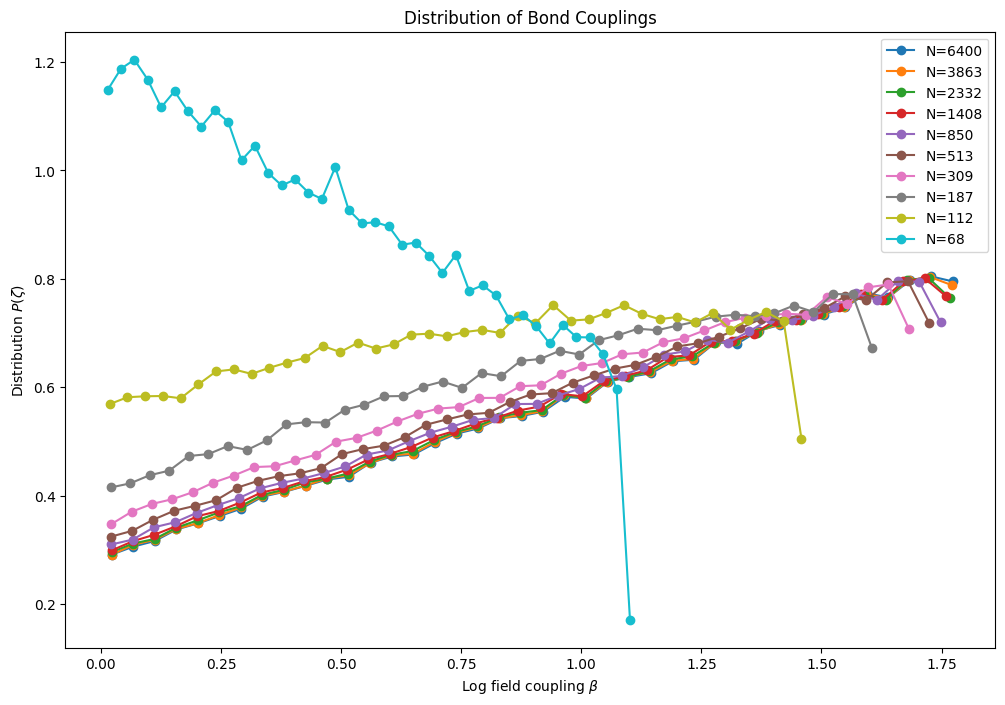

In [33]:
measure_list = input_dict['measure_list']
n_runs = input_dict['n_runs']
n_bins_J = 40
width_list = []
plt.figure(figsize=(12, 8))

for i,step in enumerate(measure_list[:-1]): 
    n,bins = np.histogram(J_dist_list[i], density=True, bins = n_bins_J)
    width = bins[1]-bins[0]
    x = (bins[1:]-width/2)
    y = n
    if i%2==0: plt.plot(x, y, label="N="+str(step), marker='o')

    popt, pcov = curve_fit(exponential_dist_norm, x[:20], y[:20])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    width_list.append(1/popt[0])


#plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $P(\zeta)$")
plt.title("Distribution of Bond Couplings")

plt.legend()

[ 0.43450754 10.79442917]


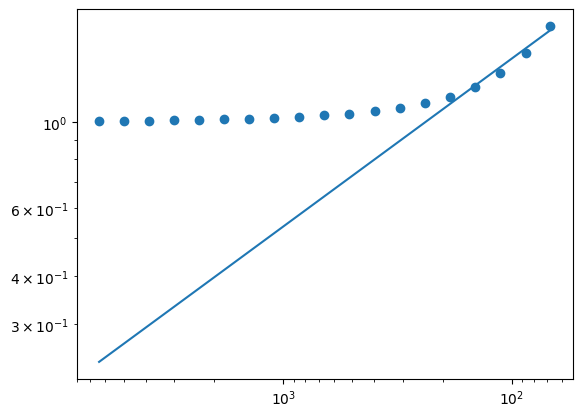

In [36]:
plt.scatter(measure_list[:-1], width_list)
x = measure_list[:-1]

popt, pcov = curve_fit(power_law_scale, x[-5:], width_list[-5:])
plt.plot(x, power_law_scale(x, *popt))
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
print(popt)

In [41]:
def process_decimation_type(Omegas, dec_types, poly_degree = 4, convolve_window = 500):
    sorted_dec = np.array([x for _,x in sorted(zip(Omegas,dec_types))])
    sorted_Omegas = np.array(sorted(Omegas))[convolve_window+1:-convolve_window]

    window_size = convolve_window

    mask = np.ones(window_size)/window_size
    convolved_data=np.convolve(sorted_dec,mask,'same')[convolve_window+1:-convolve_window]

    poly = PolynomialFeatures(degree = poly_degree)

    poly_features = poly.fit_transform(sorted_Omegas.reshape(-1, 1))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, convolved_data)
    y_predicted = poly_reg_model.predict(poly_features)
    return [-np.log(sorted_Omegas), y_predicted, convolved_data]


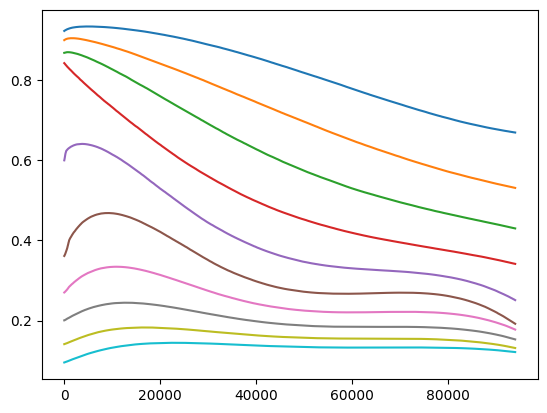

In [57]:


for ts in ts_list:
    with open("Ising_2D_output_"+str(ts)+".pkl", "rb") as fp:   # Unpickling
        output_data = pickle.load(fp)
    Omegas = np.array([])
    dec_types = np.array([])
    h_array, J_array = [], []


    for core, item in enumerate(output_data):
        J_dist_list, h_dist_list, Omega_list_composite, decimation_type_composite = item
        Omegas = np.concatenate((Omegas, Omega_list_composite))
        dec_types = np.concatenate((dec_types, decimation_type_composite))
        if core==0:
            h_array = h_dist_list
            J_array = J_dist_list

        else:
            for i in range(len(input_dict['measure_list'])):
                h_array[i] = np.concatenate((h_array[i], h_dist_list[i]))
                J_array[i] = np.concatenate((J_array[i], J_dist_list[i]))
    dec_type_data = process_decimation_type(Omegas, dec_types, poly_degree=4, convolve_window=500)
    #plt.plot(dec_type_data[0], dec_type_data[2])
    plt.plot(dec_type_data[1])
#plt.gca().invert_xaxis()
#plt.xscale('log')
#plt.ylim(0, 1)

In [21]:
log_file = pd.read_csv("log_file.csv")
log_file[lambda df: (df['L'] == 30) & (df['a']==0.1)]

,L,steps,a,b,w,n_runs,ts
109,30,892,0.1,0.105,0.5,60,1678142955
110,30,892,0.1,0.105,0.7,60,1678143132
111,30,892,0.1,0.105,0.9,60,1678143314
112,30,892,0.1,0.105,1.1,60,1678143498
113,30,892,0.1,0.105,1.3,60,1678143686
114,30,892,0.1,0.105,1.5,60,1678143872
115,30,892,0.1,0.105,1.7,60,1678144057
116,30,892,0.1,0.105,1.9,60,1678144241
117,30,892,0.1,0.105,2.1,60,1678144429
118,30,892,0.1,0.105,2.3,60,1678144618


In [22]:
L = 30
fixed_length_slice = log_file[log_file['L']==L]
ts_list = fixed_length_slice['ts'].tolist()

w_vals = fixed_length_slice['w'].tolist()
largest_clust_size = []
var_lcs = [] 
c_list = []
c_dict = {50:'red', 40:'blue', 60:'green', 80:'cyan', 30:'black'}

for index, ts in enumerate(ts_list):

    with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []

    for core_pair in clust_list_final:
        clust_list_temp, reverse_list_temp = core_pair
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])
    
    largest_clust_size.append(largest_clust_list.mean()/L**2)
    var_lcs.append(largest_clust_list.std()/L**2)
    c_list.append(c_dict[L])

Text(0.5, 1.0, 'Largest Spin Cluster and Variance in Size')

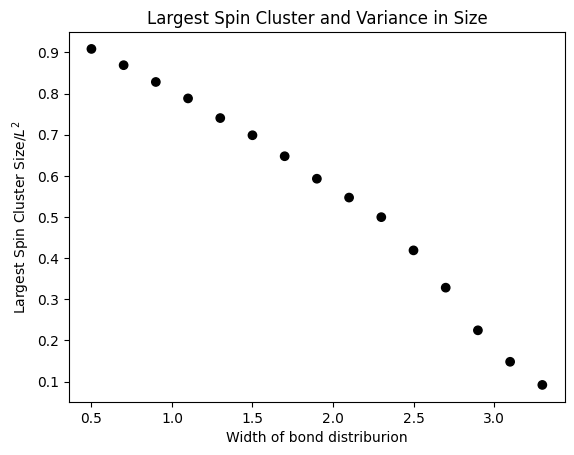

In [23]:
#plt.errorbar(w_vals, largest_clust_size, yerr=var_lcs, marker='o', linestyle='')
plt.scatter(w_vals, largest_clust_size, c=c_list)
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster and Variance in Size")


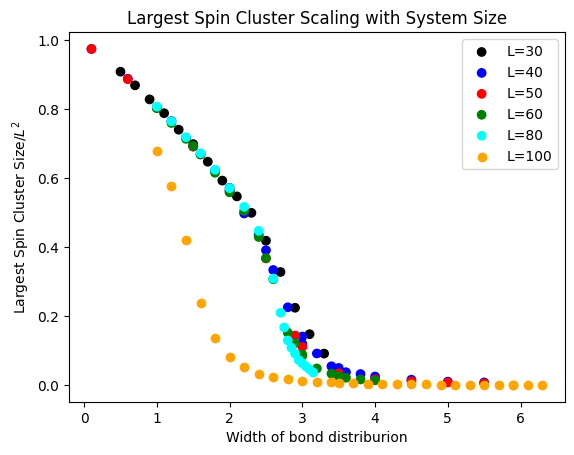

In [24]:
data_L100 = np.load("Cluster_size_L100.npz")
w_100 = data_L100['arr_0']
lcz_100 = data_L100['arr_1']

for L in [30, 40, 50, 60, 80]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    largest_clust_size = []
    var_lcs = [] 
    c_list = []

    for index, ts in enumerate(ts_list):

        with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

        largest_clust_size.append(largest_clust_list.mean()/L**2)
        var_lcs.append(largest_clust_list.std()/L**2)
        c_list.append(c_dict[L])

    plt.scatter(w_vals, largest_clust_size, c=c_list, label='L='+str(L))
    
plt.scatter(w_100, lcz_100, c='orange', label='L=100')
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster Scaling with System Size")
plt.legend()

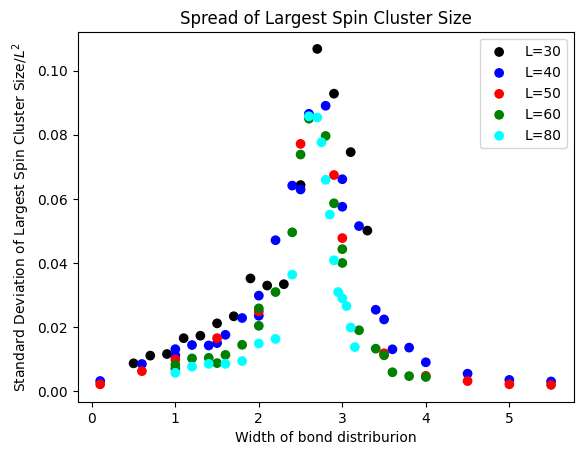

In [25]:
for L in [30, 40, 50, 60, 80]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    largest_clust_size = []
    var_lcs = [] 
    c_list = []
    c_dict = {50:'red', 40:'blue', 60:'green', 80:'cyan', 30:'black'}

    for index, ts in enumerate(ts_list):

        with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp, reverse_list_temp = core_pair
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

        largest_clust_size.append(largest_clust_list.mean()/L**2)
        var_lcs.append(largest_clust_list.std()/L**2)
        c_list.append(c_dict[L])


    sorted_y = np.array([x for _,x in sorted(zip(w_vals,var_lcs))])
    sorted_x = np.array(sorted(w_vals))
    plt.scatter(sorted_x, sorted_y, c=c_list, label='L='+str(L))

    
plt.ylabel("Standard Deviation of Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Spread of Largest Spin Cluster Size")
plt.legend()

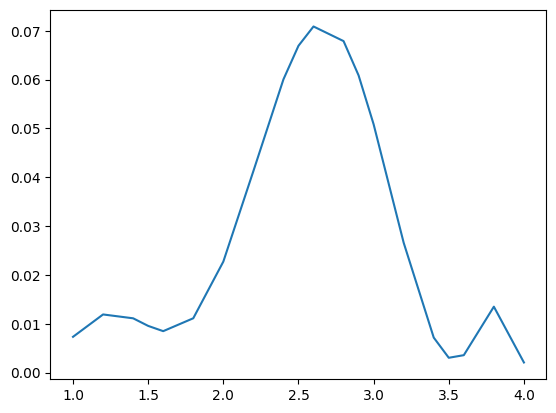

In [68]:
sorted_y = np.array([x for _,x in sorted(zip(w_vals,var_lcs))])
sorted_x = np.array(sorted(w_vals))

poly_degree = 7

poly = PolynomialFeatures(degree = poly_degree)
poly_features = poly.fit_transform(sorted_x.reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, sorted_y)
y_predicted = poly_reg_model.predict(poly_features)

plt.plot(sorted_x, y_predicted)

[0.55425482 2.95642123]


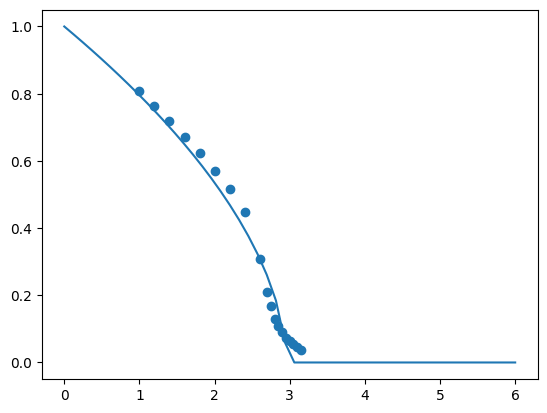

In [99]:
x = np.linspace(0, 6)

def order_param_func(x, scaling, crit_point):
    return np.piecewise(x, [x < crit_point, x >= crit_point], [lambda x: (1-x/crit_point)**scaling, 0])


popt, pcov = curve_fit(order_param_func, w_vals, largest_clust_size)

plt.plot(x, order_param_func(x, *popt))
plt.scatter(w_vals, largest_clust_size)
print(popt)

In [16]:
def check_percolation(clust_dict, L):
    percolation_check = np.zeros(L, dtype=bool)
    for x in range(L):
        start_ind = index_map(x, 0, L)
        end_index = index_map(x, L-1, L)
        percolation_check[x] = (clust_dict[start_ind] == clust_dict[end_index])
    return percolation_check.mean()
        

In [116]:
w_vals = log_file['w'].tolist()
p_perc_clust = []
c_list = []
#color_dict = {50:'blue', 60:'red', 40:'green'}

for index, ts in enumerate(ts_list):

    with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    L = log_file['L'][index]
    clust_dict_list, reverse_dict_list = [], []
    perc_cluster = []

    for core_pair in clust_list_final:
        clust_list_temp, reverse_list_temp = core_pair
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    perc_prob_temp = np.array([check_percolation(clust, L) for clust in clust_dict_list])
    
    p_perc_clust.append(perc_prob_temp.mean())
    c_list.append(c_dict[L])

Text(0.5, 0, 'Width of coupling parameter')

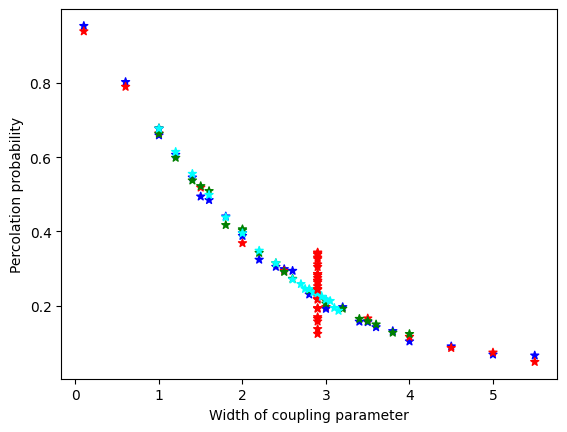

In [117]:


#np.savez("perc_prob_L60.npz", w_vals, p_perc_clust)

plt.scatter(w_vals, p_perc_clust, c=c_list, marker='*')
plt.ylabel("Percolation probability")
plt.xlabel("Width of coupling parameter")

In [109]:
L = 50
fixed_length_slice = log_file[log_file['L']==L]
ts_list = fixed_length_slice['ts'].tolist()

a_vals = fixed_length_slice['a'].tolist()

largest_clust_size = []
var_lcs = [] 

for index, ts in enumerate(ts_list):

    with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []

    for core_pair in clust_list_final:
        clust_list_temp, reverse_list_temp = core_pair
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])
    
    largest_clust_size.append(largest_clust_list.mean()/L**2)
    var_lcs.append(largest_clust_list.std()/L**2)


In [110]:
#a_vals = log_file['a'].tolist()
p_perc_clust = []
c_list = []

for index, ts in enumerate(ts_list):

    with open("Ising_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []
    perc_cluster = []

    for core_pair in clust_list_final:
        clust_list_temp, reverse_list_temp = core_pair
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp

    perc_prob_temp = np.array([check_percolation(clust, L) for clust in clust_dict_list])
    
    p_perc_clust.append(perc_prob_temp.mean())
    c_list.append(c_dict[L])

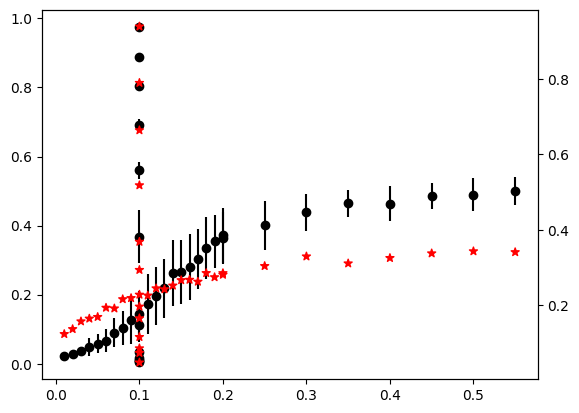

In [112]:
ax1 = plt.subplot()
l1 = ax1.errorbar(a_vals, largest_clust_size, yerr=var_lcs, marker='o', linestyle='', c='black')
ax2 = ax1.twinx()
l2 = ax2.scatter(a_vals, p_perc_clust, c=c_list, marker='*')
#plt.xscale('log')